In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
rc('text', usetex=True)

In [3]:
import vcf
import pandas as pd
from germline_cnv_evaluation import GenericCNVCallSet, GenericCopyNumberVariant

/home/slee/.pyenv/versions/anaconda-2.3.0/envs/gatk-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
hg00514_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/truth/ILL_PB_RO.5.HG00514.bed'
hg00733_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/truth/ILL_PB_RO.5.HG00733.bed'
na19240_truth_bed_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/truth/ILL_PB_RO.5.NA19240.bed'

In [26]:
gcnv_tag = 'gCNV-cb7f9e41'
# gcnv_tag = 'gCNV-6ceeb229-cyan'
hg00514_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/genotyped-segments-HG00514_1.cram.samtools.vcf'.format(gcnv_tag)
hg00733_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/genotyped-segments-HG00733_1.cram.samtools.vcf'.format(gcnv_tag)
na19240_gcnv_vcf_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/genotyped-segments-NA19240.samtools.vcf'.format(gcnv_tag)

In [27]:
ms_tag = 'ModelSegments-3797f377-less-sensitive'
hg00514_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/HG00514_1.cram.samtools.called.seg'.format(ms_tag)
hg00733_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/HG00733_1.cram.samtools.called.seg'.format(ms_tag)
na19240_ms_seg_file = '/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/{}/NA19240.samtools.called.seg'.format(ms_tag)

In [28]:
def generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name):
    truth_bed_pd = pd.read_csv(truth_bed_file, sep='\t', header=None)
    call_set = GenericCNVCallSet(sample_name)
    caller_map = {}
    for record in truth_bed_pd.values:
        contig = record[0]
        start = int(record[1]) + 1
        end = int(record[2])
        sv_type = record[3]
        var_copy_number = -1
        if sv_type == 'DEL':
            genotype = 'del'
        elif sv_type == 'CNV':
            genotype = 'cnv'
        elif sv_type == 'DUP':
            genotype = 'dup'
        else:
            continue
        quality = 99
        var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality, genotype=genotype)
        callers = record[4].split(',')
        call_set.add(var)
        caller_map[var] = callers
    
    return call_set, caller_map

In [29]:
def generate_call_set_from_gcnv_vcf(gcnv_vcf_file):
    allele_to_genotype_map = {'N': 'ref', '<DEL>': 'del', '<DUP>': 'dup'}
    quality_mode: str = "some"
    with open(gcnv_vcf_file, 'r') as f:
        vcf_reader = vcf.Reader(f)
        sample_name = vcf_reader.samples[0]
        gcnv_call_set = GenericCNVCallSet(sample_name)

        for record in vcf_reader:
            info = record.INFO
            contig = record.CHROM
            start = record.start + 1
            end = info['END']

            var_copy_number = record.samples[0]['CN']
            genotype_index = int(record.samples[0]['GT'])
            allele = str(record.alleles[genotype_index])
            num_intervals = record.samples[0]['NP']
            genotype = allele_to_genotype_map[allele]

            if quality_mode == "some":
                quality = num_intervals * record.samples[0]["QS"]
            elif quality_mode == "all":
                quality = record.samples[0]["QA"]
            else:
                raise Exception("Unknown quality calculation mode -- valid options are \"some\" and \"all\"")

            # generate variant
            if genotype != 'ref':
                sample_var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality,
                                                      genotype=genotype,
                                                      num_intervals=num_intervals,
                                                      variant_frequency=None,
                                                      variant_class=None)
                gcnv_call_set.add(sample_var)
    
    return gcnv_call_set

In [30]:
def generate_call_set_from_ms_seg(ms_seg_file, sample_name):
    call_to_genotype_map = {'0': 'ref', '-': 'del', '+': 'dup'}
    with open(ms_seg_file, 'r') as f:
        ms_seg_pd = pd.read_csv(f, sep='\t', comment='@')
        ms_call_set = GenericCNVCallSet(sample_name)
        for _, record in ms_seg_pd.iterrows():
            contig = record['CONTIG']
            start = record['START']
            end = record['END']
            var_copy_number = -1
            genotype = call_to_genotype_map[record['CALL']]
            if genotype == 'ref':
                continue
            quality = 99
            var = GenericCopyNumberVariant(contig, start, end, var_copy_number, quality, genotype=genotype)
            ms_call_set.add(var)
    return ms_call_set

In [31]:
hg00514_tuple = ('HG00514_1', hg00514_truth_bed_file, hg00514_gcnv_vcf_file, hg00514_ms_seg_file)
hg00733_tuple = ('HG00733_1', hg00733_truth_bed_file, hg00733_gcnv_vcf_file, hg00514_ms_seg_file)
na19240_tuple = ('NA19240', na19240_truth_bed_file, na19240_gcnv_vcf_file, na19240_ms_seg_file)

In [32]:
# See https://www.biorxiv.org/content/biorxiv/early/2017/09/23/193144.full.pdf for discussion of the callers
# included in the consensus call sets
other_callers = ['Delly', 'ForestSV', 'liWGS', 'lumpy', 'Manta', 'MELT', 'novoBreak', 'Pindel', 'SVelter', 'VH', 'wham']
cnv_callers = ['dCGH', 'GenomeStrip', 'GATK gCNV', 'GATK ModelSegments']

In [33]:
call_sets = {}
for sample_name, truth_bed_file, gcnv_vcf_file, ms_seg_file in [hg00514_tuple, hg00733_tuple, na19240_tuple]:
    truth_call_set, truth_caller_map = generate_truth_call_set_and_caller_map_from_bed(truth_bed_file, sample_name)
    gcnv_call_set = generate_call_set_from_gcnv_vcf(gcnv_vcf_file)
    ms_call_set = generate_call_set_from_ms_seg(ms_seg_file, sample_name)
    call_sets[sample_name] = (truth_call_set, truth_caller_map, gcnv_call_set, ms_call_set)
    print('Call sets created for', sample_name)

Call sets created for HG00514_1
Call sets created for HG00733_1
Call sets created for NA19240


In [34]:
from collections import Counter, defaultdict

min_overlap_fraction = 0.5
min_truth_lengths = [0, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

sensitivity_curves = defaultdict(list)
for min_truth_length in min_truth_lengths:
    num_tot = 0
    num_TP_gcnv = 0
    num_FN_gcnv = 0
    num_miss_gcnv = 0
    num_wrong_gcnv = 0
    num_TP_ms = 0
    num_FN_ms = 0
    num_miss_ms = 0
    num_wrong_ms = 0
    num_TP_callers = Counter()
    
    for truth_call_set, truth_caller_map, gcnv_call_set, ms_call_set in call_sets.values():
        for contig in gcnv_call_set.contig_set:
            for var in truth_call_set.iter_in_contig(contig):
                if var.length_gte_value(min_truth_length):
                    num_tot += 1
                    for caller in truth_caller_map[var]:
                        num_TP_callers[caller] += 1
                    overlapping_vars_gcnv = gcnv_call_set.get_overlapping_variants_set(var, 'reciprocal', min_overlap_fraction=min_overlap_fraction)
                    if len(overlapping_vars_gcnv) == 0:
                        num_miss_gcnv += 1
                        num_FN_gcnv += 1
                        continue
                    for overlapping_var_gcnv, _ in overlapping_vars_gcnv:
                        if not ((var.genotype == 'del' and overlapping_var_gcnv.genotype == 'del') or 
                                (var.genotype == 'dup' and overlapping_var_gcnv.genotype == 'dup') or
                                (var.genotype == 'cnv' and (overlapping_var_gcnv.genotype == 'del' or overlapping_var_gcnv.genotype == 'dup'))):
                            num_wrong_gcnv += 1
                            num_FN_gcnv += 1
                            break
                    else:
                        num_TP_gcnv += 1
                        
            for var in truth_call_set.iter_in_contig(contig):
                if var.length_gte_value(min_truth_length):
                    overlapping_vars_ms = ms_call_set.get_overlapping_variants_set(var, 'reciprocal', min_overlap_fraction=min_overlap_fraction)
                    if len(overlapping_vars_ms) == 0:
                        num_miss_ms += 1
                        num_FN_ms += 1
                        continue
                    for overlapping_var_ms, _ in overlapping_vars_ms:
                        if not ((var.genotype == 'del' and overlapping_var_ms.genotype == 'del') or 
                                (var.genotype == 'dup' and overlapping_var_ms.genotype == 'dup') or
                                (var.genotype == 'cnv' and (overlapping_var_ms.genotype == 'del' or overlapping_var_ms.genotype == 'dup'))):
                            num_wrong_ms += 1
                            num_FN_ms += 1
                            break
                    else:
                        num_TP_ms += 1
                      
    print(min_truth_length, num_tot)
    print('gCNV:', min_truth_length, num_TP_gcnv, num_FN_gcnv, num_miss_gcnv, num_wrong_gcnv, num_TP_gcnv / num_tot)
    sensitivity_curves['GATK gCNV'].append((min_truth_length, num_TP_gcnv / num_tot))
    
    print('ModelSegments:', min_truth_length, num_TP_ms, num_FN_ms, num_miss_ms, num_wrong_ms, num_TP_ms / num_tot)
    sensitivity_curves['GATK ModelSegments'].append((min_truth_length, num_TP_ms / num_tot))
    
    for caller in other_callers + ['GenomeStrip']:
        sensitivity_curves[caller].append((min_truth_length, num_TP_callers[caller] / num_tot))

0 13580
gCNV: 0 1523 12057 12024 33 0.11215022091310752
ModelSegments: 0 1883 11697 11499 198 0.138659793814433
250 6882
gCNV: 250 1523 5359 5326 33 0.22130194710839873
ModelSegments: 250 1825 5057 4861 196 0.2651845393780878
500 3012
gCNV: 500 1458 1554 1527 27 0.48406374501992033
ModelSegments: 500 1196 1816 1623 193 0.39707835325365204
1000 2145
gCNV: 1000 1227 918 899 19 0.5720279720279721
ModelSegments: 1000 974 1171 996 175 0.4540792540792541
2000 1389
gCNV: 2000 872 517 504 13 0.6277897768178545
ModelSegments: 2000 649 740 608 132 0.46724262059035276
3000 954
gCNV: 3000 637 317 313 4 0.6677148846960168
ModelSegments: 3000 466 488 408 80 0.48846960167714887
4000 761
gCNV: 4000 513 248 246 2 0.6741130091984231
ModelSegments: 4000 355 406 340 66 0.4664914586070959
5000 610
gCNV: 5000 398 212 210 2 0.6524590163934426
ModelSegments: 5000 278 332 280 52 0.4557377049180328
6000 492
gCNV: 6000 317 175 174 1 0.6443089430894309
ModelSegments: 6000 218 274 233 41 0.44308943089430897
7000 3

/home/slee/.pyenv/versions/anaconda-2.3.0/envs/gatk-dev/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/slee/.pyenv/versions/anaconda-2.3.0/envs/gatk-dev/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


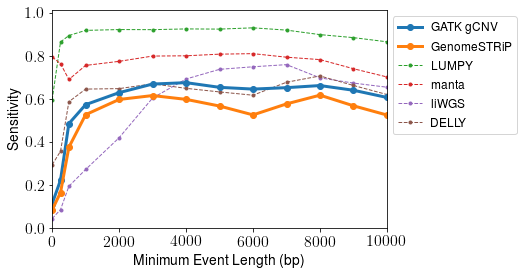

In [36]:
caller_to_label_map = {'GenomeStrip': 'GenomeSTRiP', 
                       'VH': 'VariantHunter', 
                       'wham': 'whamg', 
                       'ForestSV': 'forestSV',
                       'Manta': 'manta',
                       'lumpy': 'LUMPY',
                       'Delly': 'DELLY'}

other_callers_to_plot = ['Manta', 'lumpy', 'liWGS', 'Delly']

other_callers_sorted_by_sensitivity_at_10kb = sorted(other_callers_to_plot, 
                                                     key=lambda c: sensitivity_curves[c][-1][1],
                                                     reverse=True)

for caller in ['GATK gCNV', 'GenomeStrip'] + other_callers_sorted_by_sensitivity_at_10kb:
# for caller in ['GATK gCNV', 'GenomeStrip', 'GATK ModelSegments'] + other_callers_sorted_by_sensitivity_at_10kb:
    sensitivity_curve = sensitivity_curves[caller]
    min_truth_lengths, sensitivity = zip(*sensitivity_curve)
    xlim([0, max(min_truth_lengths)])
    ylim([0, 1.01])
    plot(min_truth_lengths, sensitivity, 
         label=caller_to_label_map[caller] if caller in caller_to_label_map.keys() else caller,
         zorder=1 if caller in cnv_callers else 0,
         lw=3 if caller in cnv_callers else 1,
         ls='solid' if caller in cnv_callers else 'dashed',
         marker='.',
         ms=12 if caller in cnv_callers else 6)
xlabel('Minimum Event Length (bp)', fontsize=14)
ylabel('Sensitivity', fontsize=14)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=16)
lgd = legend(bbox_to_anchor=(1, 1), fontsize=12)
savefig('/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/all-samples-{}.png'.format(gcnv_tag), 
        bbox_extra_artists=(lgd,), bbox_inches='tight')
savefig('/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/all-samples-{}.pdf'.format(gcnv_tag), 
        bbox_extra_artists=(lgd,), bbox_inches='tight')
# savefig('/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/all-samples-{0}-{1}.png'.format(gcnv_tag, ms_tag), 
#         bbox_extra_artists=(lgd,), bbox_inches='tight')
# savefig('/dsde/working/slee/gCNV-theano-eval-new/CHM-HGSV/all-samples-{0}-{1}.pdf'.format(gcnv_tag, ms_tag), 
#         bbox_extra_artists=(lgd,), bbox_inches='tight')
show()